# Demand Prediction

> This is a programming where in you have to build a multiple linear regression model for the prediction of demand for shared bikes. 

In [548]:
# For this we will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Ingoring the warning
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [549]:
#Importing data
raw_data = pd.read_csv('./data/bik_sharing_dataset.csv')
raw_data.head(2)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,131,670,801


In [550]:
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,365.50,2.50,0.50,6.53,0.03,3.00,0.68,1.39,20.32,23.73,62.77,12.76,849.25,3658.76,4508.01
std,210.88,1.11,0.50,3.45,0.17,2.01,0.47,0.54,7.51,8.15,14.24,5.20,686.48,1559.76,1936.01
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.42,3.95,0.00,1.50,2.00,20.00,22.00
25%,183.25,2.00,0.00,4.00,0.00,1.00,0.00,1.00,13.81,16.89,52.00,9.04,316.25,2502.25,3169.75
50%,365.50,3.00,0.50,7.00,0.00,3.00,1.00,1.00,20.47,24.37,62.62,12.13,717.00,3664.50,4548.50
75%,547.75,3.00,1.00,10.00,0.00,5.00,1.00,2.00,26.88,30.45,72.99,15.63,1096.50,4783.25,5966.00
max,730.00,4.00,1.00,12.00,1.00,6.00,1.00,3.00,35.33,42.04,97.25,34.00,3410.00,6946.00,8714.00


### 1. Preparing Data/Cleaning Data 

>In this part we will start refactoring the columns do following things.

##### Targeted Actions:
<pre>
1. Refactor
2. Handeling Null values
3. Removing outliers
4. Standardize or normalize the data
5. Handle categorical data
</pre>

Since by seeing the data above no need to removing any duplicates or na columns so skiping the below steps for this dataset.
<pre>
# Check for duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
df.dropna(inplace=True)
</pre>

##### 1.1 Reactoring

> Renaming the columns so easy to undestand, Hens this data is having less column its easy to remeber but in case of huge number of columns its good habit to rename them to understandable way.

In [551]:
#Refactoring the column names

raw_data.rename(columns={'instant':'id','dteday':'date','yr':'year','mnth':'month','weathersit':'weather',
                       'hum':'humidity','cnt':'count',},inplace=True)
raw_data.head(2)

,id,date,season,year,month,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,131,670,801


##### 1.2 Handle missing values

> Find if any column is having null value, if any column is having more then 15% of null value its better to remove that column, If the missing value is less then 15% then we can decide weather we need to remove the column or missing rows.

In [552]:
raw_data.isnull().sum()

id            0
date          0
season        0
year          0
month         0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

> Looks like the data is clean from null destruction. we no need to remove any data colums.

#### 1.3 Removing Outliers

> Identify any extreme values in data that may be outliers and decide on a strategy for handling them. This could involve removing them from the data set or transforming the data to reduce their impact.

<AxesSubplot: >

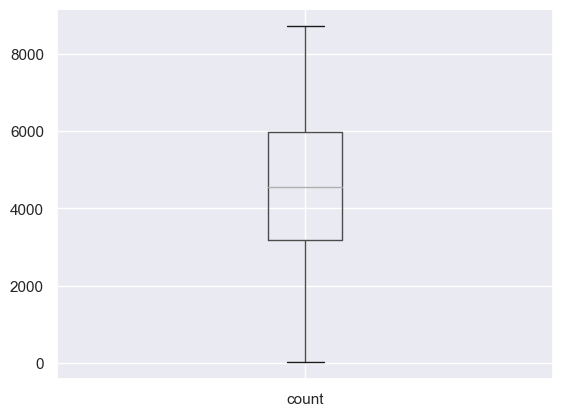

In [553]:
raw_data[['count']].boxplot()

<AxesSubplot: >

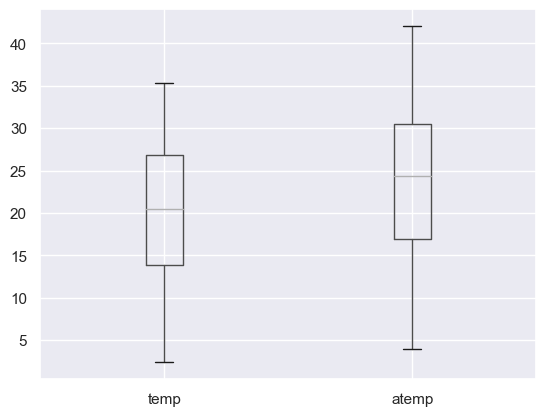

In [554]:
raw_data[['temp','atemp']].boxplot()

> From above box plot it's clear there is not outliers in out data we are free to move further without transforming the DF.

If We had any we can remove them using below
<pre>
# Check for outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
df = df[~((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).any(axis=1)]
</pre>

#### 1.4 Standardize or normalize the data

If data has different scales or units, consider standardizing or normalizing the data to improve the performance of the model.

Our data dictionary says beow statment so sking this step
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius

#### Remove irrelevant or redundant features

In [555]:
raw_data.drop(['id', 'casual','registered'], axis=1, inplace=True)

In [556]:
raw_data.shape
cleaned_data=raw_data

## Correlation analysis

>Use statistical methods to determine which variables are strongly correlated with the target variable. For example, you can use the Pearson correlation coefficient to measure the linear relationship between two variables. Features with a high correlation coefficient may be good candidates for inclusion in the model.

In [557]:
# Calculate correlation matrix
corr_matrix = raw_data.corr()

# Display correlation matrix
#print(corr_matrix)

# Extract correlation coefficients for target variable
target_corr = corr_matrix['count']

# Sort correlation coefficients in descending order
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

# Select top n features with highest correlation coefficient
n = 5
top_n_features = target_corr_sorted[1:n+1].index.tolist()

# Create new DataFrame with selected features
df_selected = raw_data[top_n_features + ['count']]

print(df_selected.head())


   atemp  temp  year  season  weather  count
0  18.18 14.11     0       1        2    985
1  17.69 14.90     0       1        2    801
2   9.47  8.05     0       1        1   1349
3  10.61  8.20     0       1        1   1562
4  11.46  9.31     0       1        1   1600


> Temprature , season and weather looks like highly corelated with the target varoable count

#### Handle categorical data

> Data contains categorical variables, decide on a strategy for encoding or transforming these variables into a numerical format that the model can understand.

> We have following catagorical variables season, month, holiday, weekday, workingday, weather and the catagories are in non understandable way so mapping them first will be right action

In [558]:
raw_data.season = raw_data.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
raw_data.month = raw_data.month.map({1:'Jan',2:'feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
raw_data.weekday = raw_data.weekday.map({1:'Wed', 2:'Thurs', 3:'Fri', 4:'Sat', 5:'Sun', 6:'Mon', 7:'Tues'})
raw_data.weather= raw_data.weather.map({1:'Clear',2:'Mist',3:'LightSnow',4:'HeavyRain'})
#raw_data.holiday= raw_data.holiday.map({1:'Holiday',0:'Working'})
#raw_data.workingday= raw_data.holiday.map({1:'Holiday',0:'Working'})


In [559]:
raw_data_with_dummies = pd.get_dummies(raw_data, columns=['season'],drop_first=True)
raw_data_with_dummies = pd.get_dummies(raw_data_with_dummies, columns=['month'],drop_first=True)
raw_data_with_dummies = pd.get_dummies(raw_data_with_dummies, columns=['weekday'],drop_first=True)
raw_data_with_dummies = pd.get_dummies(raw_data_with_dummies, columns=['weather'],drop_first=True)

#raw_data_with_dummies.to_csv('file_name.csv', sep=',', encoding='utf-8')


In [560]:
raw_data_with_dummies.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season_spring,season_summer,...,month_Oct,month_Sep,month_feb,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Wed,weather_LightSnow,weather_Mist
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,...,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,0.50,0.03,0.68,20.32,23.73,62.77,12.76,4508.01,0.25,0.25,...,0.08,0.08,0.08,0.14,0.14,0.14,0.14,0.14,0.03,0.34
std,0.50,0.17,0.47,7.51,8.15,14.24,5.20,1936.01,0.43,0.43,...,0.28,0.27,0.27,0.35,0.35,0.35,0.35,0.35,0.17,0.47
min,0.00,0.00,0.00,2.42,3.95,0.00,1.50,22.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,13.81,16.89,52.00,9.04,3169.75,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.50,0.00,1.00,20.47,24.37,62.62,12.13,4548.50,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,1.00,26.88,30.45,72.99,15.63,5966.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,35.33,42.04,97.25,34.00,8714.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## The assumptions of linear regression include

1. Linearity: The relationship between the independent and dependent variables should be linear. This means that the slope of the regression line should be constant for all values of the independent variable.

2. Independence: The observations should be independent of each other. This means that the value of one observation should not depend on the value of any other observation.

3. Homoscedasticity: The variance of the residuals (the difference between the predicted and actual values) should be constant across all levels of the independent variable. This is called homoscedasticity.

4. Normality: The residuals should be normally distributed. This means that the residuals should be symmetrically distributed around zero and follow a bell-shaped curve.

5. No multicollinearity: The independent variables should not be highly correlated with each other. This is called multicollinearity and can lead to unstable estimates of the regression coefficients.

#### Linearity

<AxesSubplot: xlabel='temp', ylabel='count'>

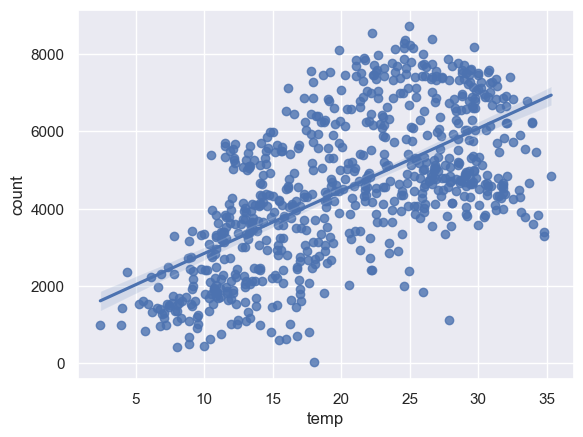

In [561]:
# check for linearity
sns.regplot(x='temp', y='count', data=raw_data_with_dummies)

#### Homoscedasticity and normality

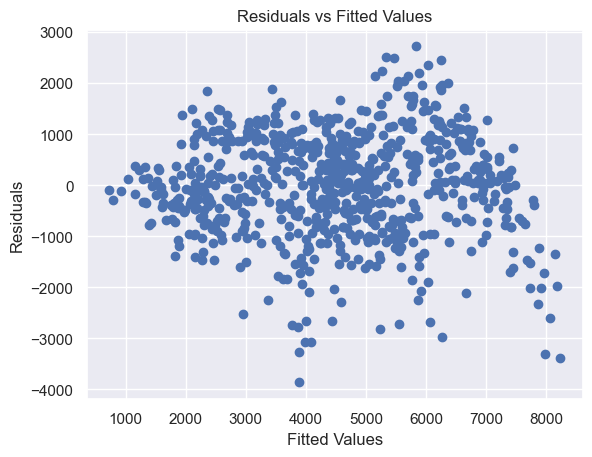

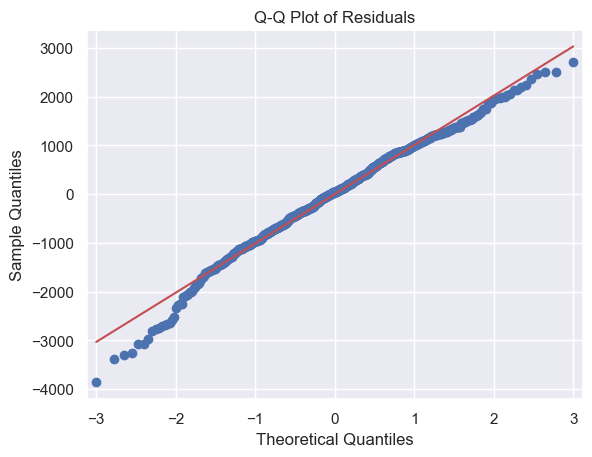

In [562]:
# create a linear regression model
X = raw_data_with_dummies[['temp','humidity','year','windspeed']]
Y = raw_data_with_dummies['count']
model = sm.OLS(Y, sm.add_constant(X)).fit()

# check for homoscedasticity
residuals = model.resid
fitted_values = model.predict()
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# check for normality
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

>  we create a linear regression model using the sm.OLS function from the statsmodels library, and then check for homoscedasticity by plotting the residuals against the fitted values. If the plot shows a random scatter of points with no pattern, then the assumption of homoscedasticity is met. If the plot shows a funnel shape or any other pattern, then the assumption of homoscedasticity is violated.


>We also check for normality of the residuals by creating a Q-Q plot using the qqplot function from the statsmodels library. If the plot shows a straight line, then the assumption of normality is met. If the plot shows a curved line or deviates significantly from a straight line, then the assumption of normality is violated.

#### No multicollinearity

In [563]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# create a linear regression model
X = raw_data_with_dummies[['temp','year','windspeed']]
Y = raw_data_with_dummies['count']
model = sm.OLS(Y, sm.add_constant(X)).fit()

# check for multicollinearity
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Features  VIF
0       temp 3.93
1       year 1.92
2  windspeed 3.72


In [564]:
raw_data_with_dummies= raw_data_with_dummies.drop('date',axis=1)

#### Hence this data meets the assumption we are considering this for Multiple linear regression.

## Building Model

##### Spliting data to train and test.

In [565]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns = ['temp', 'humidity', 'windspeed', 'count']
raw_data_with_dummies[columns] = scaler.fit_transform(raw_data_with_dummies[columns])
raw_data_with_dummies.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season_spring,season_summer,...,month_Oct,month_Sep,month_feb,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Wed,weather_LightSnow,weather_Mist
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,...,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,0.50,0.03,0.68,0.54,23.73,0.65,0.35,0.52,0.25,0.25,...,0.08,0.08,0.08,0.14,0.14,0.14,0.14,0.14,0.03,0.34
std,0.50,0.17,0.47,0.23,8.15,0.15,0.16,0.22,0.43,0.43,...,0.28,0.27,0.27,0.35,0.35,0.35,0.35,0.35,0.17,0.47
min,0.00,0.00,0.00,0.00,3.95,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.35,16.89,0.53,0.23,0.36,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.50,0.00,1.00,0.55,24.37,0.64,0.33,0.52,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,1.00,0.74,30.45,0.75,0.43,0.68,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,42.04,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [566]:
from sklearn.model_selection import train_test_split
targets = raw_data_with_dummies['count']
data_with_corelation = raw_data_with_dummies.drop('count',axis=1)
x_train, x_test, y_train, y_test = train_test_split(data_with_corelation, targets, test_size=0.2, random_state=365)

In [567]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

## Testing

In [568]:
# Once we have trained and fine-tuned our model, we can proceed to testing it
# Testing is done on a dataset that the algorithm has never seen
# Luckily we have prepared such a dataset
# Our test inputs are 'x_test', while the outputs: 'y_test' 
# We SHOULD NOT TRAIN THE MODEL ON THEM, we just feed them and find the predictions
# If the predictions are far off, we will know that our model overfitted
y_pred = reg.predict(x_test)

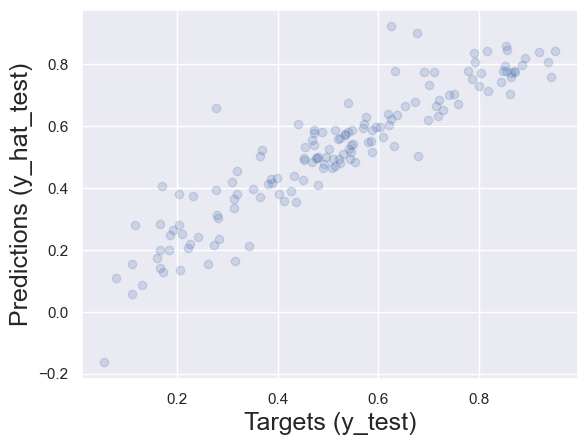

In [569]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)

plt.show()

In [570]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# print the evaluation metrics
print("MSE: ", mse)
print("R-squared: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  0.007765594636846903
R-squared:  0.8458272601058362
RMSE:  0.0881226113823626
MAE:  0.06498186690123575


#### By seeing the above values our model is predecting well

Mean squared error (MSE): The MSE is a measure of the average squared difference between the predicted and actual values. A lower value of MSE indicates better performance. However, the threshold value for MSE depends on the range and units of the target variable.

Root mean squared error (RMSE): The RMSE is the square root of the MSE and is also a measure of the average difference between the predicted and actual values. A lower value of RMSE indicates better performance. However, the threshold value for RMSE also depends on the range and units of the target variable.

R-squared (R^2): The R^2 value is a measure of how well the model fits the data, where a value of 1 indicates a perfect fit and a value of 0 indicates no correlation between the model predictions and the actual values. Generally, a higher value of R^2 indicates better performance. However, the threshold value for R^2 also depends on the specific problem domain and the goals of the analysis.

Mean absolute error (MAE): The MAE is a measure of the average absolute difference between the predicted and actual values. A lower value of MAE indicates better performance. However, the threshold value for MAE also depends on the range and units of the target variable.

In [571]:
reg.score(x_train,y_train)

0.8477771502307575

#### Score looks good

In [572]:
y_hat_test = reg.predict(x_test)

In [573]:
y_test = y_test.reset_index(drop=True)
y_test.head()
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,1.95,2.04
1,1.09,1.14
2,1.24,1.25
3,1.24,1.41
4,1.14,1.19
...,...,...
141,1.77,1.70
142,2.31,2.51
143,1.81,1.77
144,1.48,1.53


#### This shows our predection is almost near good and fair

In [574]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%']) 
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,146.00,146.00,146.00,146.00
mean,1.71,1.71,0.00,6.62
std,0.35,0.39,0.16,6.55
min,0.85,1.06,-0.64,0.06
25%,1.48,1.41,-0.07,2.50
50%,1.70,1.68,-0.00,4.46
75%,1.95,1.97,0.08,8.57
max,2.51,2.59,0.44,46.16


### All over the predection is good and the percentage diffrence shows the predection is good as possible.

<AxesSubplot: >

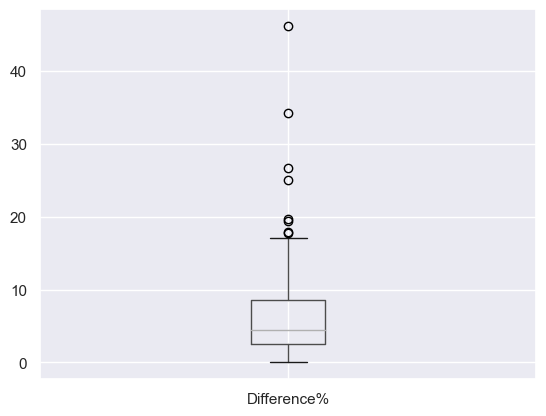

In [575]:
df_pf[['Difference%']].boxplot()